# Gykorlat 08
## Lineáris regresszió regularizálása és Bias - Variancia
### Vízfolyás
A feladat első felében implementálásra kerül egy lineáris regresszi, hogy előrejelezhessük a kifolyt víz mennyiségét egy tartályból, annak alapján, hogy abban mennyi víz van. A feladat második felében megfigyeljük a tanulóalgoritmusok debuggolását és a bias v.s. variancia hatását.

### 1: Importálás, adatok betöltése és vizualizálása

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as op

data = loadmat("Lab8data.mat")                          # adatok betöltése
X = data["X"]                                           # adatok szerkesztése változókba
Y = data["y"]
X_test = data["Xtest"]
Y_test = data["ytest"]
X_val = data["Xval"]
Y_val = data["yval"]

del data
m,n = X.shape
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (12, 1)
Shape of Y: (12, 1)


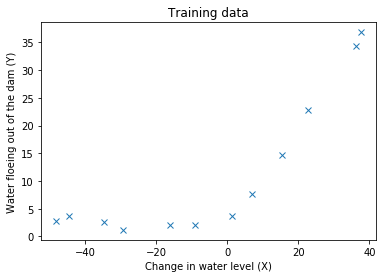

In [2]:
plt.plot(X,Y,'x')                                       # adatok megjelenítése
plt.title('Training data')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water floeing out of the dam (Y)')
plt.show()

### 2: Regularizált lineáris regresszió költségfüggvény

In [3]:
def linearRegCostFunction(w,*args):
    X,y,Lambda = args
    m,n = X.shape
    y=y.reshape(m,1)
    C=0;

    w_0 = w.copy().reshape(n,1)
    w_0[0] = 0

    penalty = (Lambda/(2*m))*np.sum(w_0**2)
    C = (1/(2*m)) * (np.sum(((X @ w)-y)**2)) + penalty

    return C

def linRegGrad(w,*args):
    X,y,Lambda = args

    m = y.shape[0]
    y=y.reshape(m,1)

    w_0 = w.copy()
    w_0[0] = 0

    w = w.reshape(2,1)
    grad = (1 / m) * np.sum((((X @ w) - y) * X), 0) + ((Lambda / m) * w_0.T)

    return grad


w = np.array([[1],[1]])
C = linearRegCostFunction(w,np.column_stack((np.ones((m,1)),X)),Y,1)
grad = linRegGrad(w,np.column_stack((np.ones((m,1)),X)),Y,1)
print('''Cost at weight (1;1):
Expected (approx.): 303.993
Computed:''',C, '''
Gradient expected (approx.): [-15.303015 598.2507]
Gradient computed:''', grad)

Cost at weight (1;1):
Expected (approx.): 303.993
Computed: 303.9931922202643 
Gradient expected (approx.): [-15.303015 598.2507]
Gradient computed: [[-15.30301567 598.25074417]]


### 3: Lineáris regresszió tanítása

Weights with the optimization:
 [[13.0879035 ]
 [ 0.36777923]]


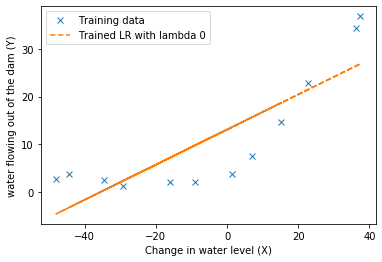

In [4]:
def trainLinearReg(X,y,Lambda):
    args = (X,y.flatten(),Lambda)
    init_w = np.ones((X.shape[1],1))
    res1 = op.fmin_ncg(linearRegCostFunction,init_w.flatten(),fprime=linRegGrad, args=args, disp=0)

    return res1.reshape((n+1,1))


Lambda = 0
w = trainLinearReg(np.column_stack((np.ones((m,1)),X)),Y,Lambda)
print('Weights with the optimization:\n',w)

plt.plot(X,Y,'x',label='Training data')
plt.plot(X,np.column_stack((np.ones((m,1)),X)) @ w,'--', label='Trained LR with lambda 0')
plt.xlabel('Change in water level (X)')
plt.ylabel('water flowing out of the dam (Y)')
plt.legend()
plt.show()

### 4: Egyenes tanítása a linaáris regresszió számára

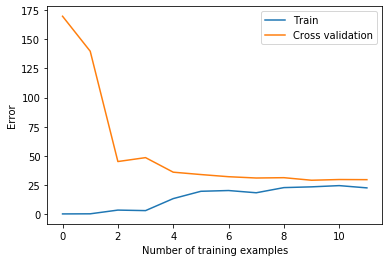

In [5]:
def learningCurve(X,Y,X_val,Y_val,Lambda):
    m = X.shape[0]

    X=np.column_stack((np.ones((m,1)),X))
    X_val = np.column_stack((np.ones((X_val.shape[0],1)),X_val))
    error_train = np.zeros((m,1))
    error_val = np.zeros((m,1))

    for i in range (1,m+1):
        w = trainLinearReg(X[0:i,:],Y[0:i],Lambda)
        error_train[i-1] = linearRegCostFunction(w,X[0:i,:],Y[0:i],Lambda)
        error_val[i-1] = linearRegCostFunction(w,X_val,Y_val,Lambda)



    return error_train, error_val


Lambda = 0
e_train,e_val = learningCurve(X,Y,X_val,Y_val,Lambda)

plt.plot(e_train, label = "Train")
plt.plot(e_val, label = "Cross validation")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend()
plt.show()

### 5: Feature mapping a polinomiális regresszióért

In [6]:
def polyFeatures(X,p=8):
    
    m=X.shape[0]
    X_poly = np.zeros((m,p))
    
    for i in range(1,m+1):
        for j in range(1,p+1):
            X_poly[i-1,j-1] = X[i-1]**j
    
    return X_poly

def featureNormalize(X):
    
    avg = np.mean(X, axis = 0)
    X_norm = X-avg
    std = np.std(X_norm, axis = 0,ddof = 1)
    X_norm = X_norm/std
    
    return X_norm,avg,std

# X:
X_p = polyFeatures(X)                                       # polynomial features
X_p,mu,sigma = featureNormalize(X_p)                        # feature normalization
X_p = np.column_stack((np.ones((m,1)),X_p))                 # bias

# X_TESZT:

X_test_p = polyFeatures(X_test)
X_test_p = (X_test_p-mu)/sigma
X_test_p = np.column_stack((np.ones((X_test_p.shape[0],1)),X_test_p))

# X_val:

X_val_p = polyFeatures(X_val)
X_val_p = (X_val_p-mu)/sigma
X_val_p = np.column_stack((np.ones((X_val_p.shape[0],1)),X_val_p))

print("""Expected Normalized Training Example 1 (approx.):
[1. -0.362 -0.755  0.182 -0.706  0.306 -0.590  0.344  -0.508]""")
print('Normalized Training Example 1:\n',X_p[0,:])



Expected Normalized Training Example 1 (approx.):
[1. -0.362 -0.755  0.182 -0.706  0.306 -0.590  0.344  -0.508]
Normalized Training Example 1:
 [ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]


### 6: Görbe tanulása a polinomiális regresszióval

In [7]:
def toPlotFit(min_x,max_x,mu,sigma,w,p=8):
    
    x = np.asmatrix(np.arange(min_x-15,max_x+25,0.05)).T
    m = x.shape[0]
    
    x_poly = polyFeatures(x)
    x_poly = (x_poly-mu)/sigma
    x_poly = np.column_stack((np.ones((m,1)),x_poly))
    
    yfitted = x_poly@w
    
    return yfitted,x


w = trainLinearReg(X_p,Y,0)

plt.plot(X,Y, 'rx')
fittedY,xplot = toPlotFit(np.min(X),np.max(X),mu,sigma,w)
plt.plot(xplot,fittedY, '--')
plt.show()


ValueError: cannot reshape array of size 9 into shape (2,1)

In [ ]:
ww = np.loadtxt("w_final.txt")